# Rationalizing The Panic Box

Panic Boxes (aka. Triple Barrier Labelling) provide a technical analysis heuristic derived from the underlying present volatility that is composed of a stop-loss, a take-profit and an expiry date on a given position.

With this in mind, we can arbitrarily construct a few different methods for building panic boxes. In advances, a generic measure of volatility is used to scale a symmetric box around a given price and this box is then used to label points in the time series.

In general, however, we are free to choose any model from time series modelling and provide some rationale to create a bounding box that appears logical from solid assumptions.

One of the major tools that I really enjoy using to construct my panic boxes are stochastic processes. Without getting too bogged down in the details, its just important to think about how these things are simulated numerically.

For instance 1D Brownian motion $W_t$ is simply simulated using the following recipe:

1.   Choose some arbitrary starting point $W_0$ and time step $\Delta t$
2.   The defining relationship is $W_{t+1} = N(W_t,\Delta t)$
3.   We apply this rule recursively and end up with a sample of $W_t$

Shown below:

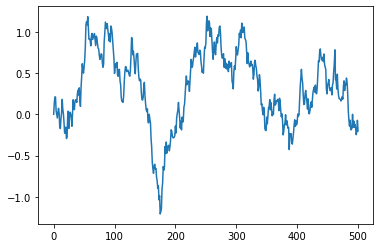

In [ ]:
from numpy import random
import matplotlib.pyplot as plt

def Simulate_Brownian_Motion(w_0,delta_t,time_limit):
  out_list = [w_0]

  for t in range(time_limit):
    out_list.append(random.normal(out_list[-1],delta_t))

  return out_list

plt.plot(Simulate_Brownian_Motion(0,0.1,500))

More complicated stochastic processes follow the same basic formula as above but the defining relationship gets respectively more complicated. The methods of deriving and solving stochastic processes makes up the subject of "Stochastic Calculus".

The defining relationship of a Geometric Brownian Motion $S_t$ (GBM for short) often used as a model of pricing is:

$$S_t = \text{Lognormal}(\ln S_{t-1} +(\mu-\frac12\sigma^2)\Delta t,\sigma\sqrt{\Delta t})$$

$\mu$ being the "drift" of the GBM and $\sigma$ being the "diffusion". Who's real meaning can be best understood in terms of "expectation curves" or the average behavior of a stochastic process. The expectation curve of a GBM is an exponential function, where the drift can be thought of the exponent factor and the diffusion can be thought of as how far a sample will move from the expectation curve.

We can look at some examples of samples of GBMs below:

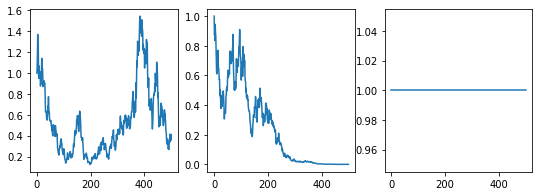

In [ ]:
import numpy as np

def Simulate_GBM(s_0,delta_t,mu,sigma,time_limit):
  out_list = [s_0]

  for t in range(time_limit):
    out_list.append(random.lognormal(np.log(out_list[-1])+(mu-0.5*sigma**2)*delta_t,
                                     sigma*delta_t**0.5))

  return out_list

fig, axs = plt.subplots(1,3,figsize=(9,3))
axs[0].plot(Simulate_GBM(1,0.01,1,1,500))
axs[1].plot(Simulate_GBM(1,0.01,-1,1,500))
axs[2].plot(Simulate_GBM(1,0,0.3,1,500))

So, the thinking goes, that if I assume that the local picture of my time series to be a GBM with static parameters ($\mu,\sigma$), I can start setting some probabilstic bounds on this local picture that I can use to define panic boxes.

However, when we analyze real data and try to fit stochastic model parameters using a rolling window, what we usually find (unsurprisingly) is that this too is a stochastic process!

Again, without getting into the details, we can derive MLE's to find the parameters of a GBM from some set of data - for reasons of computational brevity, we actually compute a quantity called $\bar\mu$ defined as:

$$\bar\mu = \mu - \sigma^2/2$$

The MLEs then have the form:

$$\hat{\bar\mu} = \dfrac{1}{N}\sum_{i=1}^N (U_i - U_{i-1}) \qquad \hat\sigma^2 = \dfrac{1}{N\Delta t} \sum_{i=1}^N (U_i-U_{i-1}-\hat{\bar\mu}\Delta t)^2$$

Where $N$ is number of samples, and $U_i$ is shorthand for $\ln S_i$.

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


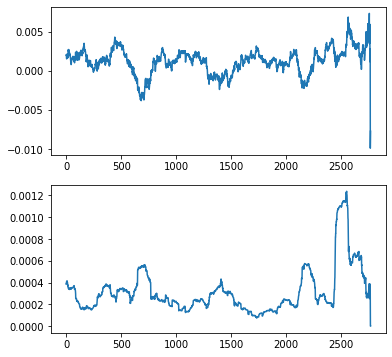

In [ ]:
import pandas_datareader as pdr

# Download hot tesla stocks
close = pdr.get_data_yahoo("AAPL","2010-1-1","2021-1-1")['Close'].to_numpy()

# MLEs
def barmu_MLE(data):
    return np.mean(np.log(data[1:])-np.log(data[:-1]))

def sigsq_MLE(data,barmu,dt):
    return np.mean((np.log(data[1:])-np.log(data[:-1])-barmu*dt)**2)/dt

# Apply rolling window transform

N = 120 # size of window

barmu = []
sigsq = []

for i in range(len(close)):
  barmu.append(barmu_MLE(close[i:i+N+1]))
  sigsq.append(sigsq_MLE(close[i:i+N+1],barmu[-1],1))

barmu = np.array(barmu)[:-1]
sigsq = np.array(sigsq)[:-1]

mu = (barmu+sigsq/2)

fig,axs = plt.subplots(2,1,figsize = (6,6))
axs[0].plot(mu)
axs[1].plot(sigsq)

Our graphs tell us that assuming constant parameters across time is a relatively stable assumption, albeit fraut with fluctuations and disruptive events such as the pandemic.

So it is important to remember that this labelling technique will offer subpar panic boxes in the event of a big fluctuation of drift or diffusion in the recent history leading up to the panic box.

Before we can draw panic boxes using this method however, we have to briefly cover the notion of expectation curves. Effectively, stochastic processes when sampled fall within a certain region of space with a given probability.

The general path of a stochastic process is its expectation curve, and either side we can create regions of whatever size we please to contain a certain number of our samples probabilistically.

For the GBM we have that:

$$\mathbb{E}(S_t) = S_0e^{\mu t}\qquad \text{Var}(S_t)=S_0^2 e^{2\mu t} (e^{\sigma^2 t} -1)$$

We now demonstrate the concept with the expected GBM +/- 1 standard deviation.

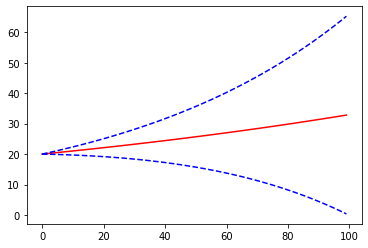

In [ ]:
# With some realistic data

s_0 = 20
mu = 0.005
sig = 0.0003
time = np.arange(0,100)

def Draw_Expectations(s_0,mu,sig,time):

  exp = s_0*np.exp(mu*time)
  var = (s_0**2)*np.exp(2*mu*time)*(np.exp(sig*time)-1)

  plt.plot(exp,color='red')
  plt.plot(exp-var,color='blue',ls='--')
  plt.plot(exp+var,color='blue',ls='--')

Draw_Expectations(s_0,mu,sig,time)

The logic for drawing a panic box is as follows:

1. At $t=0$ measure $\mu$ and $\sigma$ using an MLE on a rolling window of 120 days
2. Apply this to create a cone containing $p$% GBM samples within
3. When the bottom of this cone reaches an unacceptable loss, set this as the expiry date
4. The horizontal bars are then drawn as the symmetric $p$% mass of the CDF at the expiry date.

In actual mathematics, what we are doing is manually setting the stop loss as a percentage of the current price and then working backwards to find the $\Delta t$ that gives rise to a $\text{Lognormal}$ distribution that defines our assumed GBM such that integrating from 0 to the stop loss over the distribution's PDF gives us $1-p/2$ - the time where this happens is the expiry date.

To then find the take profit, we are then trying to find a value such that the integral from the stop loss to the take profit is $p$.

Finding the expiration date turns out to just involve solving a hellish quadratic from some straightforward rationale:

$$\text{QDF}(1-p/2) = \text{stop loss}$$

Proof by Wikipedia:

$$(\mu-\frac12\sigma^2)\Delta t + \sqrt{2\Delta t}\sigma \Phi ^{-1}(1-p) - \ln(1-\text{loss%}) = 0$$

$\Phi$ being the CDF of $N(0,1)$, since $\sqrt{2\Delta t}\sigma\Phi^{-1}(1-p)>0$ we subtract the discriminant to get the largest of the two possible time values.

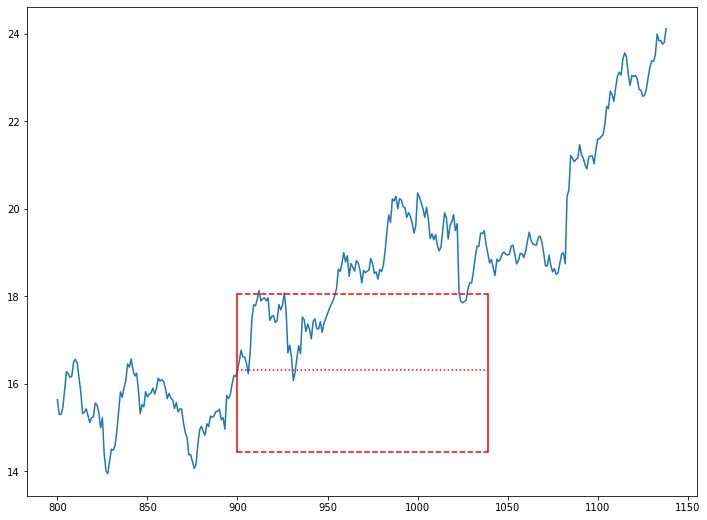

In [ ]:
from scipy.stats import norm, lognorm

def getDeltaT(mu,sigsq,p,loss):
  # Repeat quadratic evaluation seen above
  a = mu
  b = ((2*sigsq)**0.5)*norm.ppf(1-p)
  c = -np.log(1-loss)
  
  # abs is used as real contribution in edge-cases is small
  return ((-b-(abs(b**2-4*a*c))**0.5)/(2*a))**2

def getPanicBox(current_price,mu,sigsq,p,deltT):

  # Find location and scale parameters
  loc = np.log(current_price) + mu*deltT
  s = (sigsq*deltT)**0.5

  # Find corresponding exit points
  # I hate scipy lognormal parameterization
  # "Convenience", my ass
  upper = lognorm.ppf(1-p/2,s,0,np.exp(loc))
  lower = lognorm.ppf(p/2,s,0,np.exp(loc))

  return upper,lower,int(deltT)

def drawPanicBox(stock, box_loc, mle_window, plot_window,p,loss):

  # Get MLEs
  barmu = barmu_MLE(stock[box_loc-mle_window:box_loc+1])
  sigsq = sigsq_MLE(stock[box_loc-mle_window:box_loc+1],barmu,1)
  current_price = stock[box_loc]

  # Get box dimensions
  deltT = getDeltaT(barmu,sigsq,p,loss)
  u,l,t = getPanicBox(stock[box_loc],barmu,sigsq,p,deltT)

  # Begin plotting
  fig,ax = plt.subplots(1,1,figsize=(12,9))
  ax.plot([i for i in range(box_loc-plot_window,box_loc+t+plot_window)],
          stock[box_loc-plot_window:box_loc+t+plot_window])
  
  # Box back
  ax.plot([box_loc,box_loc],[u,l],color="red")
  # Box front
  ax.plot([box_loc+t,box_loc+t],[u,l],color="red")
  # Box top
  ax.plot([box_loc,box_loc+t],[u,u],color='red',ls='--')
  # Box bottom
  ax.plot([box_loc,box_loc+t],[l,l],color='red',ls='--')
  # Current price line
  ax.plot([box_loc,box_loc+t],[current_price,current_price],color='red',ls=':')

  plt.show()

drawPanicBox(close,900,60,100,0.5,0.01)

In [ ]:
Fml